In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

dftrainy = pd.read_csv('data/training_set_labels.csv')
dftrainx = pd.read_csv('data/training_set_features.csv')


In [2]:
features = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')
df = pd.merge(features, labels, on='respondent_id', how='outer')

In [3]:
X=df.drop('seasonal_vaccine', axis=1)
y=df['seasonal_vaccine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=12)

numbers=['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
onehots=['race', 'sex',  'marital_status', 'income_poverty', 'age_group', 'education', 'rent_or_own','employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
binary= ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance']

In [4]:
numbers_pipeline = Pipeline(steps=[
    ('impute_nums', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('nums', StandardScaler())  
])

In [5]:
onehots_pipeline = Pipeline(steps=[
    ('impute_ohe', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [6]:
binary_pipeline = Pipeline(steps=[('impute_bin', SimpleImputer(strategy='most_frequent', add_indicator=True))])

In [7]:
col_tr = ColumnTransformer(transformers=[('nums', numbers_pipeline, numbers),
                                        ('ohe', onehots_pipeline, onehots),
                                        ('bin', binary_pipeline, binary)],
                          remainder='passthrough', sparse_threshold=0)

In [8]:
X_train_tr = col_tr.fit_transform(X_train)
X_test_tr = col_tr.transform(X_test)

In [10]:
imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)
X_train_tr = imputer.fit_transform(X_train_tr)
X_test_tr = imputer.transform(X_test_tr)

In [16]:
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=1000)
logreg.fit(X_train_tr, y_train)
y_pred = logreg.predict(X_test_tr)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.7991612999850232
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      3603
           1       0.80      0.76      0.78      3074

    accuracy                           0.80      6677
   macro avg       0.80      0.80      0.80      6677
weighted avg       0.80      0.80      0.80      6677



In [18]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
f1

0.7765372437927012

In [19]:
C_values = [0.001, 0.01, 0.1, 1, 10]

best_f1_score = 0
best_C = None

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_tr, y_train)
    y_pred = model.predict(X_test_tr)
    f1 = f1_score(y_test, y_pred)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_C = C

In [20]:
best_C

1

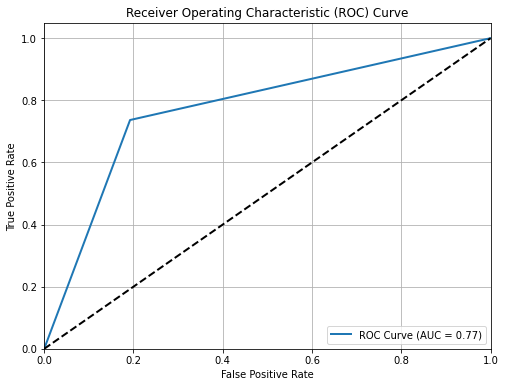

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()